In [1]:
!pip install numerapi
!pip install numerai-tools
!pip install lightgbm
!pip install dask[dataframe]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.1.3 which is incompatible.


In [5]:
from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import pandas as pd
import json

import matplotlib.pyplot as plt

import lightgbm as lgb

api = NumerAPI()

## Download v4.3 data

In [6]:
VERSION = 4.3
datasets = [dataset for dataset in api.list_datasets() if (dataset.startswith(f'v{VERSION}')) & ~("example" in dataset)]
datasets

['v4.3/features.json',
 'v4.3/live_benchmark_models.parquet',
 'v4.3/live_int8.parquet',
 'v4.3/meta_model.parquet',
 'v4.3/train_benchmark_models.parquet',
 'v4.3/train_int8.parquet',
 'v4.3/validation_benchmark_models.parquet',
 'v4.3/validation_int8.parquet']

In [7]:
%%time
for dataset in datasets:
  api.download_dataset(dataset)

v4.3/features.json: 1.12MB [00:00, 5.14MB/s]                           
v4.3/live_benchmark_models.parquet: 1.87MB [00:00, 6.98MB/s]                           
v4.3/live_int8.parquet: 6.60MB [00:00, 18.6MB/s]                            
v4.3/meta_model.parquet: 28.6MB [00:01, 21.9MB/s]                            
v4.3/train_benchmark_models.parquet: 563MB [00:26, 21.6MB/s]                           
v4.3/train_int8.parquet: 2.10GB [01:40, 20.8MB/s]                            
v4.3/validation_benchmark_models.parquet: 879MB [00:46, 19.1MB/s]                           
v4.3/validation_int8.parquet: 2.63GB [02:23, 18.3MB/s]                            

CPU times: user 1min 29s, sys: 21.2 s, total: 1min 51s
Wall time: 5min 22s


## Read data

In [8]:
feature_metadata = json.load(open("v4.3/features.json"))
for f_set in feature_metadata["feature_sets"]:
  print(f"{f_set} : {len(feature_metadata['feature_sets'][f_set])}")

small : 42
medium : 705
all : 2376
v2_equivalent_features : 304
v3_equivalent_features : 1000
fncv3_features : 400
intelligence : 35
charisma : 290
strength : 135
dexterity : 51
constitution : 335
wisdom : 140
agility : 145
serenity : 95
sunshine : 325
rain : 666
midnight : 244


In [9]:
feature_set = feature_metadata["feature_sets"]["wisdom"]

In [10]:
%%time
train = pd.read_parquet("v4.3/train_int8.parquet", columns=["era", "target"] + feature_set)
# downsample to non-overlapping eras for d20 targets
train = train[train["era"].isin(train["era"].unique()[::4])]

CPU times: user 3.39 s, sys: 1.45 s, total: 4.84 s
Wall time: 4.49 s


In [11]:
%%time
# read and make the same selections to the validation dataset as well
validation = pd.read_parquet("v4.3/validation_int8.parquet", columns=["era", "target", "data_type"] + feature_set)
validation = validation.loc[validation["data_type"]=="validation"]
validation.drop("data_type", axis=1, inplace=True)
# downsample to non-overlapping eras for d20 targets
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

CPU times: user 5.17 s, sys: 2.07 s, total: 7.25 s
Wall time: 5.57 s


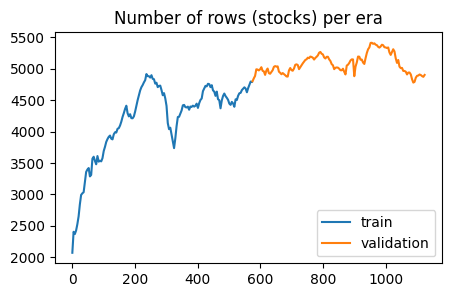

In [117]:
grouped_train = train.groupby("era").size().to_frame()
grouped_train.columns = ["size"]
grouped_train.index = grouped_train.index.astype(int)

grouped_validation = validation.groupby("era").size().to_frame()
grouped_validation.columns = ["size"]
grouped_validation.index = grouped_validation.index.astype(int)

plt.figure(figsize=(5,3))
plt.plot(grouped_train.index, grouped_train["size"], label="train")
plt.plot(grouped_validation.index, grouped_validation["size"], label="validation")
plt.title("Number of rows (stocks) per era")
plt.legend()
plt.show()

## Train a model

In [127]:
model = lgb.LGBMRegressor(
  verbose=0,
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, verbose=0)

### Evaluate

In [133]:
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [era for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

train["prediction"] = model.predict(train[feature_set])
validation["prediction"] = model.predict(validation[feature_set])

In [140]:
per_era_corr_val = validation.groupby("era").apply(lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()))
per_era_corr_train = train.groupby("era").apply(lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()))


<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

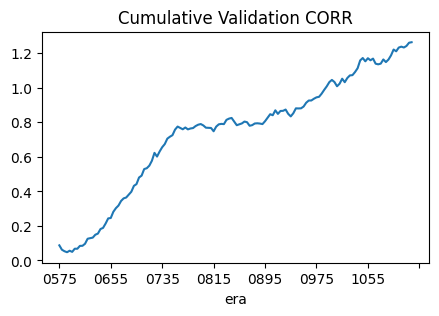

In [144]:
per_era_corr_val.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(5, 3),
  legend=False
)

In [151]:
def get_metrics(per_era_corr:pd.DataFrame):
  corr_mean = per_era_corr.mean()
  corr_std = per_era_corr.std(ddof=0)
  corr_sharpe = corr_mean / corr_std
  corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

  print(f"Corr mean : {corr_mean.values[0]:.5f}")
  print(f"Corr std : {corr_std.values[0]:.5f}")
  print(f"Corr sharpe : {corr_sharpe.values[0]:.5f}")
  print(f"Corr max dropdown : {corr_max_drawdown.values[0]:.5f}")

print("Training metrics")
get_metrics(per_era_corr_train)
print("Validation metrics")
get_metrics(per_era_corr_val)

Training metrics
Corr mean : 0.14712
Corr std : 0.01843
Corr sharpe : 7.98364
Corr max dropdown : 0.00000
Validation metrics
Corr mean : 0.00916
Corr std : 0.01716
Corr sharpe : 0.53383
Corr max dropdown : 0.04520


## Live predictions

In [152]:
live_features = pd.read_parquet(f"v4.3/live_int8.parquet", columns=feature_set)

live_predictions = model.predict(live_features[feature_set])

pd.Series(live_predictions, index=live_features.index).to_frame("prediction").to_csv("submission.csv")

## Pickle the model

In [153]:
import cloudpickle

def predict(live_features: pd.DataFrame) -> pd.DataFrame:
  live_predictions = model.predict(live_features[feature_set])
  submission = pd.Series(live_predictions, index=live_features.index)
  return submission.to_frame("prediction")

p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)